In [1]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os, time, itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 경로확인 

In [2]:
os.getcwd()

'/Users/sungjinkim/Documents/Study/Regression_Project'

### 데이터 불러오기 

In [3]:
batter = pd.read_csv('./Data/Regular_Season_Batter.csv')

#### 나이변수 추가 

In [4]:
batter['Age'] = batter['year'] - batter['year_born'].apply(lambda x: int(x[:4]))

#### height/weight 각자 다른 column으로 분류후 결측치 평균으로 채우기 

In [5]:
batter['height/weight'] = batter['height/weight'].fillna('0cm/0kg')

batter['height'] = batter['height/weight'].apply(lambda x: int(x.split('/')[0][:-2]))
batter['weight'] = batter['height/weight'].apply(lambda x: int(x.split('/')[1][:-2]))

mean_h = np.mean(batter['height'][batter['height'] != 0])
mean_w = np.mean(batter['weight'][batter['weight'] != 0])

batter['height'] = batter['height'].apply(lambda x: mean_h if x == 0 else x)
batter['weight'] = batter['weight'].apply(lambda x: mean_w if x == 0 else x)

#### 규정타석을 채운 타자 데이터 추출 후 이상치 제거 

In [6]:
batter = batter[batter['AB'] >= 396]

batter = batter.drop(1935, axis = 0)

#### 연속형 변수만 채택 

In [7]:
batter_conti = batter.drop(['batter_id', 'year', 'year_born', 'batter_name',
                            'team', 'position', 'career', 'starting_salary', 'height/weight'], axis=1)

#### Target 분리 

In [8]:
target_OPS = batter_conti['OPS']

In [9]:
batter_conti_ = batter_conti.drop(['avg', 'OPS', 'SLG', 'OBP'], axis=1)
batter_conti_1 = sm.add_constant(batter_conti_, has_constant='add')

### 학습데이터 / 평가데이터 분할 

In [10]:
feature_columns = list(batter_conti_1.columns)

X = batter_conti_1[feature_columns]
y = target_OPS
train_x, test_x, train_y, test_y = train_test_split(X, y, train_size=0.7, test_size=0.3)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((332, 20), (143, 20), (332,), (143,))

### Baseline(Full) 모델 적합 

In [11]:
full_model = sm.OLS(train_y, train_x)
fitted_full_model = full_model.fit()

#### 적합 결과 확인 

In [12]:
print(fitted_full_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2436.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):          4.94e-324
Time:                        21:43:25   Log-Likelihood:                 1096.7
No. Observations:                 332   AIC:                            -2155.
Df Residuals:                     313   BIC:                            -2083.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8293      0.027     30.578      0.0

#### VIF를 통한 다중공선성 확인 

In [13]:
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(batter_conti_.values, i) for i in range(batter_conti_.shape[1])]
vif['features'] = batter_conti_.columns
vif

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF_Factor,features
0,573.828417,G
1,716.843679,AB
2,87.500905,R
3,inf,H
4,inf,2B
5,inf,3B
6,inf,HR
7,inf,TB
8,61.559165,RBI
9,6.011886,SB


#### 잔차비교, QQ plot, Residual Plot 확인 

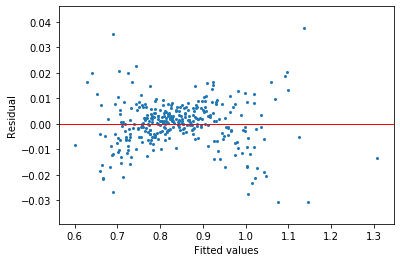

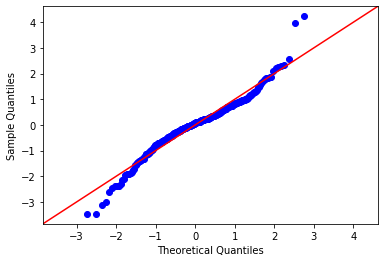

In [14]:
plt.scatter(fitted_full_model.predict(train_x), fitted_full_model.resid, s=4)
plt.axhline(y=0, color='r', linewidth=1)
plt.xlabel('Fitted values')
plt.ylabel('Residual')
plt.show()

fig = sm.qqplot(fitted_full_model.resid, fit=True, line='45')

### SLR (타점, RBI) 모델 적합 

In [15]:
RBI = train_x['RBI']
RBI1 = sm.add_constant(RBI, has_constant='add')

model_RBI = sm.OLS(train_y, RBI1)
fitted_model_RBI = model_RBI.fit()

pred_RBI = fitted_model_RBI.predict(RBI1)

#### 결과 확인 

In [16]:
print(fitted_model_RBI.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     549.4
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           3.19e-72
Time:                        21:43:26   Log-Likelihood:                 437.81
No. Observations:                 332   AIC:                            -871.6
Df Residuals:                     330   BIC:                            -864.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5850      0.011     50.956      0.0

#### 적합 그래프, QQ plot, Residual Plot 확인 

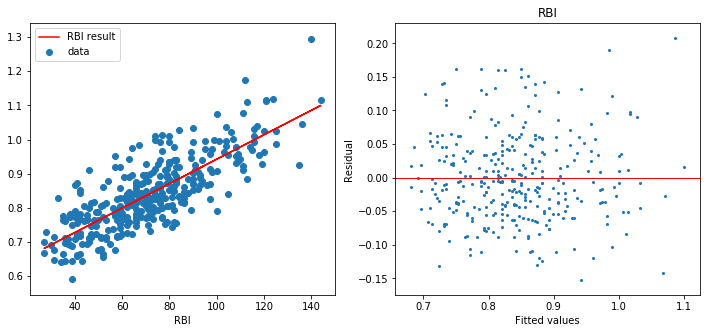

Text(0.5, 1.0, 'RBI')

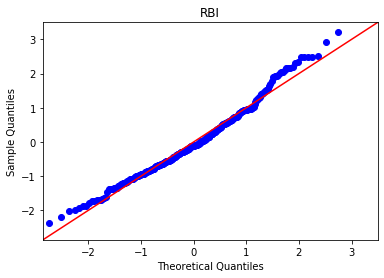

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(RBI, train_y, label='data')
plt.plot(RBI, pred_RBI, 'r', label='RBI result')
plt.xlabel('RBI')
plt.legend()

plt.subplot(122)
plt.scatter(fitted_model_RBI.predict(RBI1), fitted_model_RBI.resid, s=4)
plt.axhline(y=0, color='r', linewidth=1)
plt.title('RBI')
plt.xlabel('Fitted values')
plt.ylabel('Residual')

plt.show()

sm.qqplot(fitted_model_RBI.resid, fit=True, line='45')
plt.title('RBI')

# 다중선형회귀모형 적합 

### Baseline 모델에 대한 평가 

In [18]:
print(fitted_full_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2436.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):          4.94e-324
Time:                        21:43:26   Log-Likelihood:                 1096.7
No. Observations:                 332   AIC:                            -2155.
Df Residuals:                     313   BIC:                            -2083.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8293      0.027     30.578      0.0

#### 검증데이터 예측 

In [19]:
pred_full = fitted_full_model.predict(test_x)

#### Residual Plot 

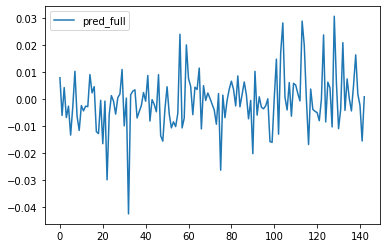

In [20]:
plt.plot(np.array(test_y - pred_full), label='pred_full')
plt.legend()
plt.show()

#### MSE 성능 평가 

In [21]:
mean_squared_error(y_true= test_y, y_pred = pred_full)

0.0001091079725462296

### 변수선택법 

In [22]:
def processSubset(X, y, feature_set):
    model = sm.OLS(y, X[list(feature_set)])
    regr = model.fit()
    AIC = regr.aic
    return {'model': regr, 'AIC': AIC}

print(processSubset(X=train_x, y=train_y, feature_set=feature_columns))

{'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3ed15ad0>, 'AIC': -2155.399522051572}


In [23]:
# getBest: 가장 낮은 AIC를 가지는 모델 선택 및 저장
def getBest(X, y, k):
    tic = time.time() # 시작시간
    results = [] # 결과 저장공간
    for combo in itertools.combinations(X.columns.difference(['const']), k): # 각 변수조합을 고려한 경우의 수
        combo = (list(combo) + ['const'])
        
        results.append(processSubset(X, y, feature_set=combo)) # 모델링된 것들을 저장
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가지는 모델 선택 및 저장
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print('Processed', models.shape[0], 'models on', k, 'predictors in', (toc - tic), 'seconds')
    return best_model

print(getBest(X=train_x, y=train_y, k=2))

Processed 171 models on 2 predictors in 0.18451404571533203 seconds
model    <statsmodels.regression.linear_model.Regressio...
AIC                                               -1408.73
Name: 48, dtype: object


### 변수 선택에 따른 학습시간과 모델저장 

In [24]:
models = pd.DataFrame(columns=['AIC', 'model'])
tic = time.time()
for i in range(1, 4):
    models.loc[i] = getBest(X=train_x, y=train_y, k=i)
toc = time.time()
print('Total elapsed time:', (toc-tic), 'seconds')

Processed 19 models on 1 predictors in 0.024026155471801758 seconds
Processed 171 models on 2 predictors in 0.17008376121520996 seconds
Processed 969 models on 3 predictors in 1.0821008682250977 seconds
Total elapsed time: 1.2933640480041504 seconds


In [25]:
models

,AIC,model
1,-1017.716861,<statsmodels.regression.linear_model.Regressio...
2,-1408.732817,<statsmodels.regression.linear_model.Regressio...
3,-1627.890494,<statsmodels.regression.linear_model.Regressio...


In [26]:
print(models.loc[3, 'model'].summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2768.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):          1.72e-232
Time:                        21:43:28   Log-Likelihood:                 817.95
No. Observations:                 332   AIC:                            -1628.
Df Residuals:                     328   BIC:                            -1613.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AB            -0.0018   4.42e-05    -40.313      0.0

### Baseline 모델과 비교 

In [27]:
print('full model Rsquared: ', '{:.5f}'.format(fitted_full_model.rsquared))
print('full model AIC: ', '{:.5f}'.format(fitted_full_model.aic))
print('selected model Rsquared: ', '{:.5f}'.format(models.loc[3, 'model'].rsquared))
print('selected model AIC: ', '{:.5f}'.format(models.loc[3, 'model'].aic))

full model Rsquared:  0.99291
full model AIC:  -2155.39952
selected model Rsquared:  0.96200
selected model AIC:  -1627.89049


### Plot & Result 

Text(0, 0.5, 'BIC')

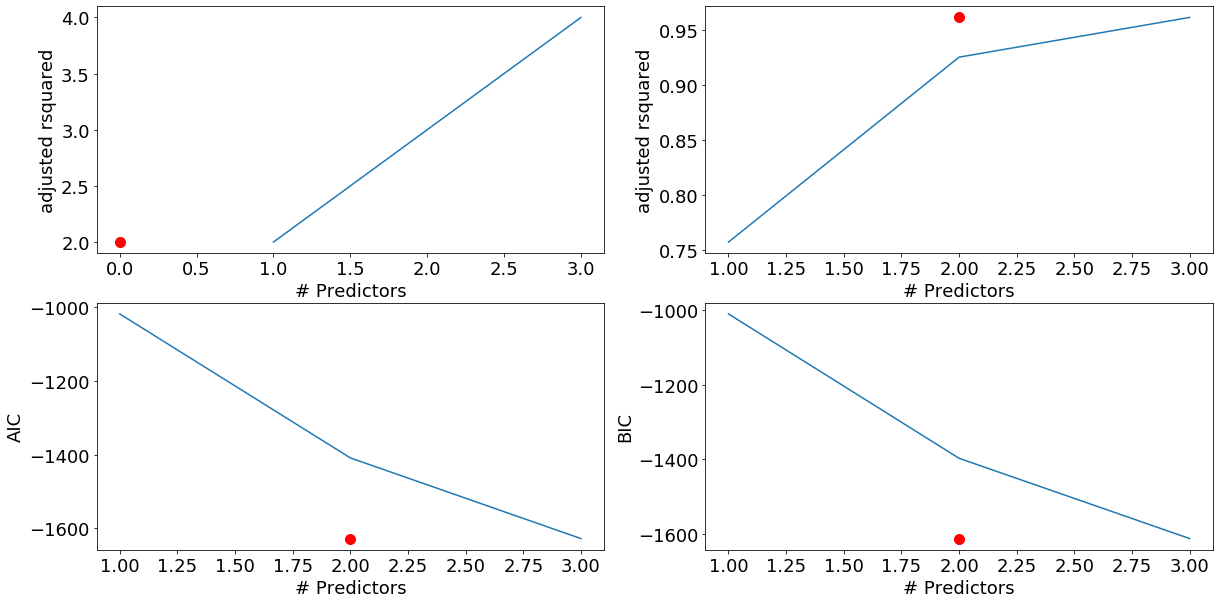

In [28]:
plt.figure(figsize=(20, 10))
plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

## Mallow Cp
plt.subplot(221)
Cp = models.apply(lambda row: (row[1].params.shape[0] + (row[1].mse_total - fitted_full_model.mse_total) * 
                              (train_x.shape[0] - row[1].params.shape[0])/fitted_full_model.mse_total), axis=1)
plt.plot(Cp)
plt.plot(Cp.argmin(), Cp.min(), 'or')
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

## adj-rsquared plot
## adj-rsquared = Explained variation / Total variation
adj_rsquared = models.apply(lambda row: row[1].rsquared_adj, axis=1)
plt.subplot(222)
plt.plot(adj_rsquared)
plt.plot(adj_rsquared.argmax(), adj_rsquared.max(), 'or')
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

## aic
aic = models.apply(lambda row: row[1].aic, axis=1)
plt.subplot(223)
plt.plot(aic)
plt.plot(aic.argmin(), aic.min(), 'or')
plt.xlabel('# Predictors')
plt.ylabel('AIC')

## bic
bic = models.apply(lambda row: row[1].bic, axis=1)
plt.subplot(224)
plt.plot(bic)
plt.plot(bic.argmin(), bic.min(), 'or')
plt.xlabel('# Predictors')
plt.ylabel('BIC')

# 전진선택법 

In [29]:
def forward(X, y, predictors):
    # 데이터 변수들이 미리정의된 predictors에 있는지 없는지 확인 및 분류
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y= y, feature_set=predictors+[p]+['const']))
    # 데이터프레임으로 변환
    models = pd.DataFrame(results)

    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()] # index
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

In [30]:
def forward_model(X,y):
    Fmodels = pd.DataFrame(columns=["AIC", "model"])
    tic = time.time()
    # 미리 정의된 데이터 변수
    predictors = []
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const'])) + 1):
        Forward_result = forward(X=X,y=y,predictors=predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                break
        Fmodels.loc[i] = Forward_result
        predictors = Fmodels.loc[i]["model"].model.exog_names
        Fmodel_before = Fmodels.loc[i]["AIC"]
        predictors = [ k for k in predictors if k != 'const']
    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")

    return(Fmodels['model'][len(Fmodels['model'])])

In [31]:
Forward_best_model = forward_model(X=train_x, y=train_y)

Processed  19 models on 1 predictors in 0.03225517272949219
Selected predictors: ['TB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f3434d0>
Processed  18 models on 2 predictors in 0.02756667137145996
Selected predictors: ['TB', 'AB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3ee5d290>
Processed  17 models on 3 predictors in 0.024011850357055664
Selected predictors: ['TB', 'AB', 'H', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f2bd490>
Processed  16 models on 4 predictors in 0.023892879486083984
Selected predictors: ['TB', 'AB', 'H', 'BB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3ee5d090>
Processed  15 models on 5 predictors in 0.020600080490112305
Selected predictors: ['TB', 'AB', 'H', 'BB', 'HBP', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 

In [32]:
Forward_best_model.aic

-2163.218807548596

In [33]:
print(Forward_best_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     4387.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:43:29   Log-Likelihood:                 1092.6
No. Observations:                 332   AIC:                            -2163.
Df Residuals:                     321   BIC:                            -2121.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TB             0.0022   3.28e-05     66.707      0.0

# 후진소거법 

In [34]:
def backward(X,y,predictors):
    tic = time.time()
    results = []
    # 데이터 변수들이 미리정의된 predictors 조합 확인
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X=X, y= y,feature_set=list(combo)+['const']))
    models = pd.DataFrame(results)
    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors) - 1, "predictors in",
          (toc - tic))
    print('Selected predictors:',best_model['model'].model.exog_names,' AIC:',best_model[0] )
    return best_model

In [35]:
def backward_model(X, y):
    Bmodels = pd.DataFrame(columns=["AIC", "model"], index = range(1,len(X.columns)))
    tic = time.time()
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X,y,predictors)['AIC']
    while (len(predictors) > 1):
        Backward_result = backward(X=train_x, y= train_y, predictors = predictors)
        if Backward_result['AIC'] > Bmodel_before:
            break
        Bmodels.loc[len(predictors) - 1] = Backward_result
        predictors = Bmodels.loc[len(predictors) - 1]["model"].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const']

    toc = time.time()
    print("Total elapsed time:", (toc - tic), "seconds.")
    return (Bmodels['model'].dropna().iloc[0])

In [36]:
Backward_best_model = backward_model(X=train_x,y=train_y)

Processed  19 models on 18 predictors in 0.03507685661315918
Selected predictors: ['2B', '3B', 'AB', 'Age', 'BB', 'CS', 'E', 'G', 'GDP', 'H', 'HBP', 'HR', 'R', 'RBI', 'SO', 'TB', 'height', 'weight', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f2f03d0>
Processed  18 models on 17 predictors in 0.030514001846313477
Selected predictors: ['2B', '3B', 'AB', 'Age', 'BB', 'CS', 'G', 'GDP', 'H', 'HBP', 'HR', 'R', 'RBI', 'SO', 'TB', 'height', 'weight', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f30ea90>
Processed  17 models on 16 predictors in 0.030028820037841797
Selected predictors: ['2B', '3B', 'AB', 'Age', 'BB', 'CS', 'G', 'GDP', 'H', 'HBP', 'HR', 'RBI', 'SO', 'TB', 'height', 'weight', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f2f0f50>
Processed  16 models on 15 predictors in 0.027966022491455078
Selected predictors: ['2B', '3B', 'AB', 'BB',

In [37]:
Backward_best_model.aic

-2163.218807548597

In [38]:
print(Backward_best_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     4387.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:43:29   Log-Likelihood:                 1092.6
No. Observations:                 332   AIC:                            -2163.
Df Residuals:                     321   BIC:                            -2121.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AB            -0.0017   2.65e-05    -63.852      0.0

# 단계적 선택법

In [39]:
def Stepwise_model(X, y):
    Stepmodels = pd.DataFrame(columns=['AIC', 'model'])
    tic = time.time()
    predictors = []
    Smodel_before = processSubset(X, y, predictors+['const'])['AIC']
    # 변수 1~10개 : 0~9 -> 1~10
    for i in range(1, len(X.columns.difference(['const']))+1):
        Forward_result = forward(X=X, y=y, predictors=predictors)
        print('forward')
        Stepmodels.loc[i] = Forward_result
        predictors = Stepmodels.loc[i]['model'].model.exog_names
        predictors = [k for k in predictors if k != 'const']
        Backward_result = backward(X=X, y=y, predictors=predictors)
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            Smodel_before = Stepmodels.loc[i]['AIC']
            predictors = [k for k in predictors if k != 'const']
            print('backward')
        if Stepmodels.loc[i]['AIC'] > Smodel_before: break
        else: Smodel_before = Stepmodels.loc[i]['AIC']
        
    toc = time.time()
    print('Total elapsed time:', (toc - tic), 'seconds')
    
    return (Stepmodels['model'][len(Stepmodels['model'])])

In [40]:
Stepwise_best_model = Stepwise_model(X=X, y=y)

Processed  19 models on 1 predictors in 0.021574974060058594
Selected predictors: ['TB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f2f0bd0>
forward
Processed  1 models on 0 predictors in 0.0018651485443115234
Selected predictors: ['const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f884d90>
Processed  18 models on 2 predictors in 0.02575373649597168
Selected predictors: ['TB', 'AB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f884810>
forward
Processed  2 models on 1 predictors in 0.004360198974609375
Selected predictors: ['TB', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f2f4e50>
Processed  17 models on 3 predictors in 0.022329092025756836
Selected predictors: ['TB', 'AB', 'H', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f884e50>
forward
Process

Processed  9 models on 11 predictors in 0.015014886856079102
Selected predictors: ['TB', 'AB', 'H', 'BB', 'HBP', 'G', 'RBI', 'GDP', 'height', 'weight', 'CS', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f8ab310>
forward
Processed  11 models on 10 predictors in 0.02016305923461914
Selected predictors: ['TB', 'AB', 'H', 'BB', 'HBP', 'G', 'RBI', 'GDP', 'height', 'weight', 'const']  AIC: <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fea3f8841d0>
backward
Total elapsed time: 0.729442834854126 seconds


In [41]:
Stepwise_best_model.aic

-3068.408136385265

In [42]:
print(Stepwise_best_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     5893.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:43:30   Log-Likelihood:                 1545.2
No. Observations:                 475   AIC:                            -3068.
Df Residuals:                     464   BIC:                            -3023.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
TB             0.0022   2.83e-05     77.551      0.0

# 최종모델선정 

In [50]:
batter_conti_f = batter_conti[['TB', 'AB', 'H', 'BB', 'HBP', 'G', 'height', 'weight']]

In [52]:
batter_conti_f1 = sm.add_constant(batter_conti_f, has_constant='add')
model_final = sm.OLS(target_OPS, batter_conti_f1)
fitted_model_final = model_final.fit()

In [53]:
print(fitted_model_final.summary())

                            OLS Regression Results                            
Dep. Variable:                    OPS   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     7100.
Date:                Sun, 21 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:48:58   Log-Likelihood:                 1535.5
No. Observations:                 475   AIC:                            -3053.
Df Residuals:                     466   BIC:                            -3016.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8194      0.023     35.733      0.0

# 성능평가 

In [56]:
pred_y_full = fitted_full_model.predict(test_x)
pred_y_forward = Forward_best_model.predict(test_x[Forward_best_model.model.exog_names])
pred_y_backward = Backward_best_model.predict(test_x[Backward_best_model.model.exog_names])
pred_y_stepwise = Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])
pred_y_final = fitted_model_final.predict(test_x[fitted_model_final.model.exog_names])

In [59]:
perf_mat = pd.DataFrame(columns=['ALL', 'FORWARD', 'BACKWARD', 'STEPWISE', 'FINAL'],
                       index=['MSE', 'RMSE', 'MAE', 'MAPE'])

In [60]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_ture, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [61]:
perf_mat.loc['MSE']['ALL'] = metrics.mean_squared_error(test_y,pred_y_full)
perf_mat.loc['MSE']['FORWARD'] = metrics.mean_squared_error(test_y,pred_y_forward)
perf_mat.loc['MSE']['BACKWARD'] = metrics.mean_squared_error(test_y,pred_y_backward)
perf_mat.loc['MSE']['STEPWISE'] = metrics.mean_squared_error(test_y,pred_y_stepwise)
perf_mat.loc['MSE']['FINAL'] = metrics.mean_squared_error(test_y,pred_y_final)

perf_mat.loc['RMSE']['ALL'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_full))
perf_mat.loc['RMSE']['FORWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_forward))
perf_mat.loc['RMSE']['BACKWARD'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_backward))
perf_mat.loc['RMSE']['STEPWISE'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_stepwise))
perf_mat.loc['RMSE']['FINAL'] = np.sqrt(metrics.mean_squared_error(test_y, pred_y_final))

perf_mat.loc['MAE']['ALL'] = metrics.mean_absolute_error(test_y, pred_y_full)
perf_mat.loc['MAE']['FORWARD'] = metrics.mean_absolute_error(test_y, pred_y_forward)
perf_mat.loc['MAE']['BACKWARD'] = metrics.mean_absolute_error(test_y, pred_y_backward)
perf_mat.loc['MAE']['STEPWISE'] = metrics.mean_absolute_error(test_y, pred_y_stepwise)
perf_mat.loc['MAE']['FINAL'] = metrics.mean_absolute_error(test_y, pred_y_final)

perf_mat.loc['MAPE']['ALL'] = mean_absolute_percentage_error(test_y, pred_y_full)
perf_mat.loc['MAPE']['FORWARD'] = mean_absolute_percentage_error(test_y, pred_y_forward)
perf_mat.loc['MAPE']['BACKWARD'] = mean_absolute_percentage_error(test_y, pred_y_backward)
perf_mat.loc['MAPE']['STEPWISE'] = mean_absolute_percentage_error(test_y, pred_y_stepwise)
perf_mat.loc['MAPE']['FINAL'] = mean_absolute_percentage_error(test_y, pred_y_final)

print(perf_mat)

              ALL      FORWARD     BACKWARD     STEPWISE        FINAL
MSE   0.000109108  0.000105408  0.000105408  0.000100287  0.000105796
RMSE    0.0104455    0.0102668    0.0102668    0.0100144    0.0102857
MAE    0.00742883   0.00735808   0.00735808   0.00717049   0.00733131
MAPE     0.852478     0.847571     0.847571     0.828791     0.850136


In [62]:
print(len(fitted_full_model.params))
print(len(Forward_best_model.params))
print(len(Backward_best_model.params))
print(len(Stepwise_best_model.params))
print(len(fitted_model_final.params))

20
11
11
11
9


# 잔차분석 

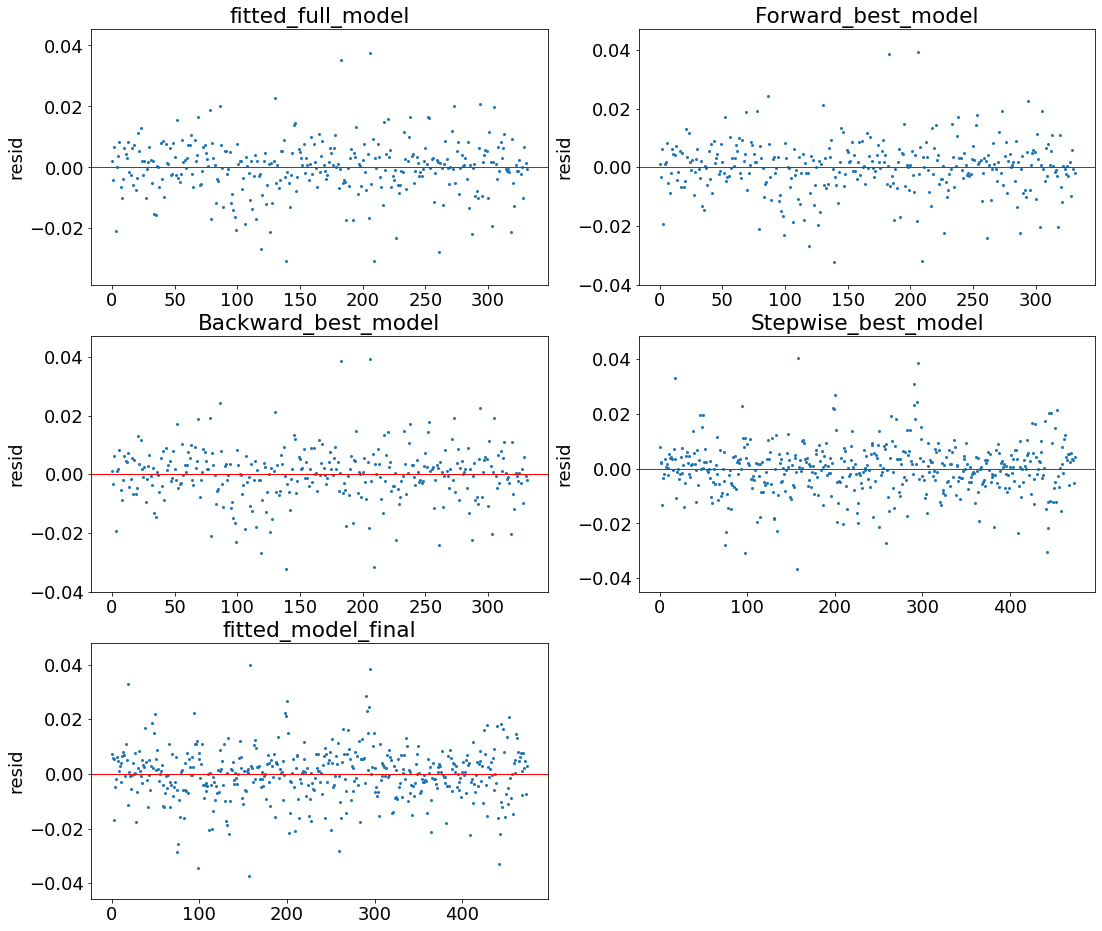

In [77]:
plt.figure(figsize=(18, 16))

plt.subplot(321)
plt.scatter(np.arange(len(fitted_full_model.resid)), fitted_full_model.resid, s=4)
plt.title('fitted_full_model')
plt.ylabel('resid')
plt.axhline(y=0, color='r', linewidth=1)

plt.subplot(322)
plt.scatter(np.arange(len(Forward_best_model.resid)), Forward_best_model.resid, s=4)
plt.title('Forward_best_model')
plt.ylabel('resid')
plt.axhline(y=0, color='r', linewidth=1)

plt.subplot(323)
plt.scatter(np.arange(len(Backward_best_model.resid)), Backward_best_model.resid, s=4)
plt.title('Backward_best_model')
plt.ylabel('resid')
plt.axhline(y=0, color='r', linewidth=1)

plt.subplot(324)
plt.scatter(np.arange(len(Stepwise_best_model.resid)), Stepwise_best_model.resid, s=4)
plt.title('Stepwise_best_model')
plt.ylabel('resid')
plt.axhline(y=0, color='r', linewidth=1)

plt.subplot(325)
plt.scatter(np.arange(len(fitted_model_final.resid)), fitted_model_final.resid, s=4)
plt.title('fitted_model_final')
plt.ylabel('resid')
plt.axhline(y=0, color='r', linewidth=1)

plt.show()

# 예측결과 

In [80]:
print(test_y[:10], fitted_model_final.predict(np.array(test_x[fitted_model_final.model.exog_names])[:10]),
     fitted_full_model.predict(test_x)[:10],
     Stepwise_best_model.predict(test_x[Stepwise_best_model.model.exog_names])[:10])

914     0.742000
2438    0.805000
1202    0.928000
981     0.860000
1987    0.857000
1040    0.950000
2320    1.044000
1832    0.874259
2443    0.964000
1018    0.681000
Name: OPS, dtype: float64 [0.72865629 0.81267443 0.92427051 0.85953923 0.85728136 0.95934203
 1.05000768 0.87132295 0.97128338 0.69722241] 914     0.734105
2438    0.811092
1202    0.923746
981     0.866886
1987    0.859645
1040    0.963374
2320    1.046859
1832    0.863983
2443    0.970371
1018    0.692651
dtype: float64 914     0.732462
2438    0.810950
1202    0.920690
981     0.864943
1987    0.858524
1040    0.962508
2320    1.047371
1832    0.868319
2443    0.969273
1018    0.695588
dtype: float64
